### Import Dependencies

In [1]:
import csv      #for read write csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load CSV Data

In [2]:
df = pd.read_csv(r'water_data.csv')
array = np.array(df)

#delete redundent column and check data
#each column represents the following water data: 
#index, date, time, water temperature, pH, dissolve oxygen (DO), and electrical conductivity (EC)
data = array[:,0:7]
print(data[0,:])


[1 '12/9/2023' '18:48:45' 24.33 8.58 11.598 1896]


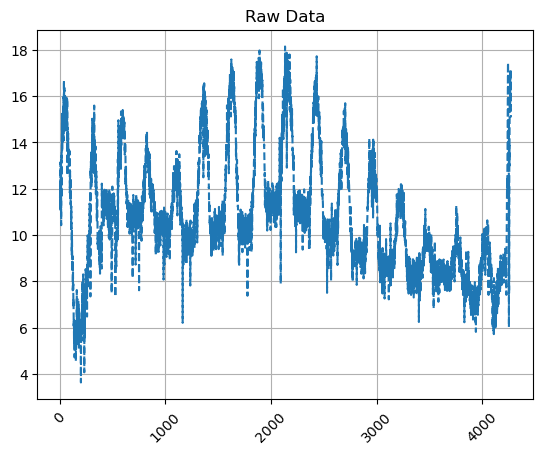

In [8]:
#Plot one of the data and have a look
plt.figure()
plt.title('Raw Data')
plt.plot(np.transpose(data[:,0]), np.transpose(data[:,5]), linestyle='--')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Z-Normalize Data

In [49]:
#first, we are only interested in water parameter datas, which are column 3 to 6
water_data = data[:,3:7]

#define empty array for putting normalized water data
water_data_norm = np.zeros(water_data.shape)

#define empty array for mean and variance
water_data_var = np.zeros(water_data.shape[1])
water_data_mean = np.zeros(water_data.shape[1])

#carryout normalization by each column
for i in range(water_data.shape[1]):
    #calculate mean and variance for each data column
    water_data_var[i] = np.var(water_data[:,i])
    water_data_mean[i] = np.mean(water_data[:,i])
    #conduct z-normalization by subtracting sample mean and divided by standard deviation
    water_data_norm[:,i] = (water_data[:,i] - water_data_mean[i]) / np.sqrt(water_data_var[i])

print(water_data_norm)

[[-0.8843013   1.3163763   0.28932974  2.13567881]
 [-0.74359002  1.53735541  0.46883172  2.13567881]
 [-0.72703575  1.58646188  0.09496703  2.13567881]
 ...
 [ 3.04733755  2.6668042   2.18016211 -0.82066757]
 [ 3.09700036  2.42127185  1.90367431 -0.82066757]
 [ 3.05561469  2.32305891  1.65143298 -0.76070112]]


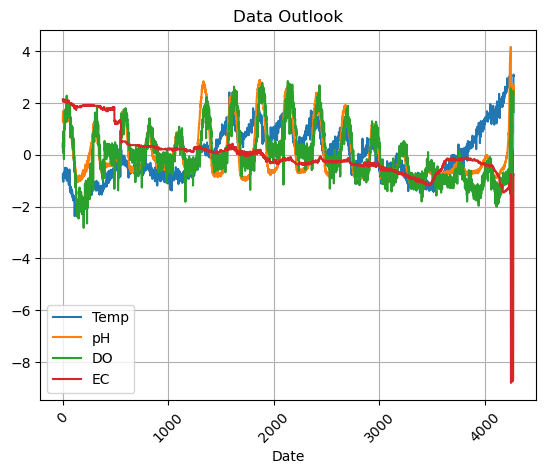

In [50]:
#Plot normalized data and have a look
plt.figure()
plt.title('Data Outlook')
plt.xlabel('Date')
plt.ylabel('') 


plt.plot(np.transpose(data[:,0]), np.transpose(water_data_norm[:,0]), linestyle='-',label='Temp')
plt.plot(np.transpose(data[:,0]), np.transpose(water_data_norm[:,1]), linestyle='-',label='pH')
plt.plot(np.transpose(data[:,0]), np.transpose(water_data_norm[:,2]), linestyle='-',label='DO')
plt.plot(np.transpose(data[:,0]), np.transpose(water_data_norm[:,3]), linestyle='-',label='EC')
plt.xticks(rotation=45)

plt.legend()
plt.grid()
plt.show()

### Fitting the model

In [63]:
#Now, we can relatively easily fit a multivariant gaussian distribution to our data as the kernel of our model.
#We first obtain the covariance matrix
water_data_cov = np.cov(np.transpose(water_data_norm))

#then, we fit the maximum likelyhood multivariant gaussian distribution
#note that in our test case, dimension of data = 4 (temp, pH, DO, EC)
#also, note that we should only input already z-normalized data into the function. Thus the mean of the data would be zero.

def water_mul_var_gauss(water_data_input,dim):
    constant_term = 1/((2*np.pi())^(dim/2))
    one_over_det_sqrt = 1/np.linalg.det(water_data_cov)^(1/2)
    exponent_term = (-1/2)*np.transpose(water_data_input)*np.linalg.inv(water_data_input)*water_data_norm
    return (constant_term*one_over_det_sqrt*np.exp(exponent_term))

#note that we shall define a normalizing function to normalize our input to the distribution first.
#THIS HAVE TO BE UPDATED WHEN WE UPDATE THE TRAINING DATA

def water_data_normalize(input):
    output = np.divide((input - water_data_mean),np.sqrt(water_data_var))
    return output




In [69]:
#now we can test our function with different 
print(water_data_normalize(water_data_mean))   # 0, 0, 0, 0


[0. 0. 0. 0.]
